In [ ]:
!pip install stable-baselines3 gym numpy matplotlib shimmy
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade stable-baselines3 gymnasium

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import gym
import numpy as np
import pandas as pd
from gym import spaces

class InteractiveUPSBatteryEnv(gym.Env):
    def __init__(self, csv_path):
        super(InteractiveUPSBatteryEnv, self).__init__()

        self.data = pd.read_csv(csv_path)
        self.max_steps = 500

        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)  # 0=充電, 1=放電, 2=保持

    def reset(self):
        self.current_step = 0

        # 從 CSV 隨機選一筆作為初始狀態
        init_row = self.data.sample(n=1).iloc[0]
        self.input_voltage = init_row['input_voltage']
        self.battery_voltage = init_row['battery_voltage']
        self.battery_capacity = init_row['battery_capacity']
        self.load_level = init_row['load_level']

        return self._get_obs()

    def _get_obs(self):
        return np.array([
            self.input_voltage / 120.0,
            self.battery_voltage / 24.0,
            self.battery_capacity / 100.0,
            self.load_level / 100.0,
        ], dtype=np.float32)

    def step(self, action):
        done = False
        reward = 0

        # 模擬外部變動：市電與負載變化
        self.input_voltage += np.random.uniform(-2, 2)
        self.input_voltage = np.clip(self.input_voltage, 90, 130)

        self.load_level += np.random.uniform(-3, 3)
        self.load_level = np.clip(self.load_level, 10, 100)

        # === 動作影響狀態 ===
        if action == 0:  # 充電
            if self.input_voltage >= 110:
                self.battery_capacity += 2
                reward = 1
            else:
                reward = -1
        elif action == 1:  # 放電
            if self.input_voltage < 110 and self.load_level > 30 and self.battery_capacity > 5:
                self.battery_capacity -= 3
                reward = 2
            else:
                reward = -2
        elif action == 2:  # 保持
            reward = 0.2

        # 安全邊界處理
        self.battery_capacity = np.clip(self.battery_capacity, 0, 100)
        self.battery_voltage = 24.0 * (self.battery_capacity / 100.0)

        self.current_step += 1
        if self.current_step >= self.max_steps or self.battery_capacity <= 0:
            done = True
            reward -= 5  # 電池耗盡懲罰

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        print(f"[Step {self.current_step}] 電壓: {self.input_voltage:.1f}V, 電池: {self.battery_capacity:.1f}%, 負載: {self.load_level:.1f}%")

# === 訓練模型 ===
csv_path = "/content/battery_health_data_shuffled.csv"  # 替換為你的 CSV 檔路徑
env = DummyVecEnv([lambda: InteractiveUPSBatteryEnv(csv_path)])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# === 儲存模型 ===
model.save("ppo_ups_battery_model")
print("✅ 模型已儲存為 ppo_ups_battery_model.zip")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1041 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 708         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016146507 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.00696     |
|    learning_rate        | 0.0003      |
|    loss                 | 30.8        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 94.3        |
-----------------------------------------
-----------------

In [ ]:
# 讀取模型
model = PPO.load("ppo_ups_battery_model")

# 單筆資料（範例）
# [input_voltage, battery_voltage, battery_capacity, load_level]
current_status = [45, 24, 10, 0]

# 正規化輸入（電壓最大 24V，容量最大 100）



obs = np.array([
    current_status[0],                 # input_voltage
    current_status[1] ,          # battery_voltage normalized
    current_status[2] / 100.0,         # battery_capacity normalized
    current_status[3] / 100.0             # load_level
], dtype=np.float32)



  # 模型預測
action, _ = model.predict(obs, deterministic=True)
action_name = ["保持", "充電", "放電"][action]

print(action)

2


In [ ]:
model = PPO.load("ppo_ups_battery_model")

# 建立測試環境（與訓練相同）
test_env = InteractiveUPSBatteryEnv(csv_path)

obs = test_env.reset()
total_reward = 0

for i in range(500):  # 最多 200 步
    action, _ = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    total_reward += reward
    print(f'{test_env.render()}, {action}')

    if done:
        print("🔚 測試結束。")
        break

print(f"✅ 總回饋分數：{total_reward:.2f}")

[Step 1] 電壓: 90.0V, 電池: 64.9%, 負載: 35.6%
None, 1
[Step 2] 電壓: 90.0V, 電池: 64.9%, 負載: 34.6%
None, 2
[Step 3] 電壓: 90.0V, 電池: 64.9%, 負載: 34.8%
None, 2
[Step 4] 電壓: 91.9V, 電池: 64.9%, 負載: 37.6%
None, 2
[Step 5] 電壓: 90.2V, 電池: 64.9%, 負載: 35.6%
None, 2
[Step 6] 電壓: 90.9V, 電池: 64.9%, 負載: 38.3%
None, 2
[Step 7] 電壓: 90.0V, 電池: 64.9%, 負載: 40.1%
None, 2
[Step 8] 電壓: 90.0V, 電池: 64.9%, 負載: 43.1%
None, 2
[Step 9] 電壓: 91.0V, 電池: 64.9%, 負載: 45.2%
None, 2
[Step 10] 電壓: 92.8V, 電池: 64.9%, 負載: 44.1%
None, 2
[Step 11] 電壓: 94.0V, 電池: 64.9%, 負載: 46.4%
None, 2
[Step 12] 電壓: 92.9V, 電池: 61.9%, 負載: 47.5%
None, 1
[Step 13] 電壓: 93.9V, 電池: 61.9%, 負載: 44.8%
None, 2
[Step 14] 電壓: 94.2V, 電池: 58.9%, 負載: 42.7%
None, 1
[Step 15] 電壓: 94.1V, 電池: 58.9%, 負載: 40.3%
None, 2
[Step 16] 電壓: 92.6V, 電池: 58.9%, 負載: 41.1%
None, 2
[Step 17] 電壓: 92.5V, 電池: 58.9%, 負載: 42.2%
None, 2
[Step 18] 電壓: 91.8V, 電池: 55.9%, 負載: 41.7%
None, 1
[Step 19] 電壓: 93.0V, 電池: 55.9%, 負載: 39.3%
None, 2
[Step 20] 電壓: 93.5V, 電池: 55.9%, 負載: 39.5%
None, 2
[Step 21]

In [ ]:
test_env = InteractiveUPSBatteryEnv(csv_path)

obs = test_env.reset()
total_reward = 0

for i in range(200):  # 最多 200 步
    action, _ = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    total_reward += reward
    test_env.render()

    if done:
        print("🔚 測試結束。")
        break

print(f"✅ 總回饋分數：{total_reward:.2f}")

[Step 1] 電壓: 90.0V, 電池: 46.8%, 負載: 60.6%
[Step 2] 電壓: 90.4V, 電池: 46.8%, 負載: 59.9%
[Step 3] 電壓: 90.0V, 電池: 46.8%, 負載: 57.2%
[Step 4] 電壓: 90.7V, 電池: 46.8%, 負載: 58.8%
[Step 5] 電壓: 91.8V, 電池: 46.8%, 負載: 60.2%
[Step 6] 電壓: 90.1V, 電池: 46.8%, 負載: 59.1%
[Step 7] 電壓: 92.0V, 電池: 43.8%, 負載: 60.8%
[Step 8] 電壓: 90.0V, 電池: 43.8%, 負載: 59.9%
[Step 9] 電壓: 90.5V, 電池: 43.8%, 負載: 57.3%
[Step 10] 電壓: 92.4V, 電池: 43.8%, 負載: 55.9%
[Step 11] 電壓: 93.4V, 電池: 43.8%, 負載: 57.1%
[Step 12] 電壓: 92.4V, 電池: 43.8%, 負載: 54.7%
[Step 13] 電壓: 93.4V, 電池: 43.8%, 負載: 52.0%
[Step 14] 電壓: 92.2V, 電池: 43.8%, 負載: 52.1%
[Step 15] 電壓: 93.4V, 電池: 43.8%, 負載: 53.0%
[Step 16] 電壓: 94.6V, 電池: 43.8%, 負載: 52.7%
[Step 17] 電壓: 94.5V, 電池: 43.8%, 負載: 54.1%
[Step 18] 電壓: 93.8V, 電池: 43.8%, 負載: 54.0%
[Step 19] 電壓: 94.1V, 電池: 43.8%, 負載: 53.0%
[Step 20] 電壓: 92.7V, 電池: 43.8%, 負載: 50.4%
[Step 21] 電壓: 92.3V, 電池: 43.8%, 負載: 49.5%
[Step 22] 電壓: 94.1V, 電池: 43.8%, 負載: 46.7%
[Step 23] 電壓: 92.2V, 電池: 43.8%, 負載: 48.9%
[Step 24] 電壓: 94.1V, 電池: 43.8%, 負載: 50.7%
[

In [ ]:
import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# UPS 專用電池環境（使用 CSV）
class UPSBatteryEnv(gym.Env):
    def __init__(self, csv_path):
        # super(UPSBatteryEnv, self).__init__()

        self.data = pd.read_csv(csv_path)
        self.max_steps = len(self.data)

        # 狀態空間：4 維連續數值（標準化）
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

        # 動作空間：0=充電、1=放電、2=保持
        self.action_space = spaces.Discrete(3)
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        return np.array([
            row['input_voltage'],
            row['battery_voltage'] / 24.0,
            row['battery_capacity'] / 100.0,
            row['load_level'] / 100.0,
        ], dtype=np.float32)

    def step(self, action):
        row = self.data.iloc[self.current_step]
        done = False
        reward = 0

        input_voltage = row['input_voltage']
        battery_capacity = row['battery_capacity']
        load_level = row['load_level']

        # UPS reward 策略
        if input_voltage < 110:  # 市電異常，應放電支援負載
            if action == 1 and battery_capacity > 10 and load_level > 20:
                reward = 2
            else:
                reward = -2
        elif input_voltage >= 110 and battery_capacity < 95:
            if action == 0:
                reward = 1
            elif action == 1:
                reward = -1
            else:
                reward = 0.1
        else:
            reward = 0.2  # 保持穩定也算合理

        self.current_step += 1
        if self.current_step >= self.max_steps - 1:
            done = True

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        row = self.data.iloc[self.current_step]
        print(f"Step {self.current_step} - Input: {row['input_voltage']}V, Battery: {row['battery_capacity']}%, Load: {row['load_level']}%")

# === 訓練模型 ===
csv_path = "/content/battery_health_data_shuffled.csv"  # 替換為你的 CSV 檔路徑
env = DummyVecEnv([lambda: UPSBatteryEnv(csv_path)])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# === 儲存模型 ===
model.save("ppo_ups_battery_model")
print("✅ 模型已儲存為 ppo_ups_battery_model.zip")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 985  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------


KeyboardInterrupt: 

In [ ]:
from stable_baselines3 import PPO
import numpy as np

# 讀取模型
model = PPO.load("ppo_battery_model.zip")

# 單筆資料（範例）
# [input_voltage, battery_voltage, battery_capacity, load_level]
current_status = [0.6, 20.5, 70, 0.4]

# 正規化輸入（電壓最大 24V，容量最大 100）
obs = np.array([
    current_status[0],                 # input_voltage
    current_status[1] / 24.0,          # battery_voltage normalized
    current_status[2] / 100.0,         # battery_capacity normalized
    current_status[3]                  # load_level
], dtype=np.float32)

# 模型預測
action, _ = model.predict(obs, deterministic=True)
action_name = ["保持", "充電", "放電"][action]

print(f"建議行動：{action_name}")

# NEW

In [ ]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

class BatteryEnv(gym.Env):
    def __init__(self):
        super(BatteryEnv, self).__init__()
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 20, 0, 0]),   # 最低值
            high=np.array([100, 5000, 30, 100, 1]),  # 最高值
            dtype=np.float32
        )
        self.action_space = gym.spaces.Discrete(3)  # 減少/維持/增加充電功率

    def reset(self):
        self.state = np.array([100, 1000, 24.0, 10, 0])  # 初始狀態
        return self.state

    def step(self, action):
        battery_charge, runtime, voltage, load, status = self.state
        if action == 0:
            battery_charge -= 1  # 減少充電功率
        elif action == 1:
            pass  # 維持
        else:
            battery_charge += 1  # 增加充電功率

        # 假設充電影響電壓和運行時間
        voltage = 24.0 + (battery_charge - 50) * 0.05
        runtime = 1000 + (battery_charge - 50) * 20

        # 獎勵函數
        reward = -abs(1000 - runtime) - abs(24 - voltage)

        done = False
        self.state = np.array([battery_charge, runtime, voltage, load, status])
        return self.state, reward, done, {}

env = DummyVecEnv([lambda: BatteryEnv()])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# 測試
obs = env.reset()
for _ in range(100):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1182 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 801           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00016275945 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 6.2e+07       |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00027      |
|    value_loss           | 1.3e+08       |
-------------------------

In [ ]:
import pandas as pd

obs = env.reset()
done = False

df = pd.DataFrame(columns=['state', 'reward'])

while not done:
    action, _ = model.predict(obs)  # PPO 預測最佳充電動作
    obs, reward, done, _ = env.step(action)
    print(f"狀態：{obs}, 獎勵：{reward}")
    new_row = pd.DataFrame([{'state': obs, 'reward': reward}])
    df = pd.concat([df, new_row], ignore_index=True)


串流輸出內容已截斷至最後 5000 行。
狀態：[[3.1890e+03 6.3780e+04 1.8095e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62936.95]
狀態：[[3.1890e+03 6.3780e+04 1.8095e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62936.95]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-62916.9]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-62916.9]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-62916.9]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-62916.9]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-6291

KeyboardInterrupt: 

In [ ]:
df

,state,reward
0,"[22.5, 25.25, 100.0]",19.975
1,"[25.0, 25.5, 100.0]",22.450
2,"[27.5, 25.75, 100.0]",24.925
3,"[30.0, 26.0, 100.0]",27.400
4,"[32.5, 26.25, 100.0]",29.875
5,"[35.0, 26.5, 100.0]",32.350
6,"[37.5, 26.75, 100.0]",34.825
7,"[40.0, 27.0, 100.0]",37.300
8,"[42.5, 27.25, 100.0]",39.775
9,"[45.0, 27.5, 100.0]",42.250


In [ ]:
highest_score = df.loc[df['reward'] == df['reward'].max()]
highest_score['state']
# type(highest_score['state'])

,state
30,"[100.0, 33.0, 100.0]"


*   Input_voltage 輸入電壓
*   Battery_voltage 電池電壓
*   Battery_normal_voltage 電池正常電壓 定值為24
*   Battery_capacity 目前電池電量
*   Load_level 負載率





PPO + Cosine_Similarity

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import cosine

# PPO 策略網路
class PPOPolicy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPOPolicy, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_probs = self.softmax(self.fc3(x))
        return action_probs

# 初始化 PPO 模型
state_dim = 5  # 5 個狀態變數
action_dim = 2  # 充電 (1) / 不充電 (0)
policy = PPOPolicy(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# 設定理想狀態 (S_ideal)
S_ideal = np.array([112, 24.0, 24.0, 80, 50])  # 理想狀態

# 當前電池狀態 (S_current) - 假設 UPS 輸入 210V，電池電壓 23.5V，電池容量 50%，負載 40%
S_current = np.array([112, 13.5, 24.0, 80, 100])

# 轉換成 PyTorch Tensor
S_current_tensor = torch.tensor(S_current, dtype=torch.float32)

# 使用 PPO 選擇充電策略
action_probs = policy(S_current_tensor)
action = torch.argmax(action_probs).item()  # 選擇機率最高的動作

# PPO 選擇的充電模式
charging_modes = {0: "不充電", 1: "充電"}
chosen_action = charging_modes[action]
print(f"PPO 選擇的充電策略: {chosen_action}")

# 更新 S_PPO 狀態（模擬 PPO 選擇後的影響）
if action == 1:  # 充電
    S_PPO = np.array([112, 23.8, 24.0, 70, 40])  # 充電後電壓上升，電池容量增加
else:  # 不充電
    S_PPO = S_current  # 保持原狀

# 計算餘弦相似度
cosine_similarity = 1 - cosine(S_PPO, S_ideal)
print(f"餘弦相似度: {cosine_similarity:.4f}")

# 判斷 PPO 是否選擇了理想狀態
if cosine_similarity > 0.95:
    print("PPO 選擇的策略接近理想狀態")
    print(action)
    print(S_PPO)
else:
    print("PPO 可能需要調整")
    print(not(action))

PPO 選擇的充電策略: 充電
餘弦相似度: 0.9969
PPO 選擇的策略接近理想狀態
1


# Final

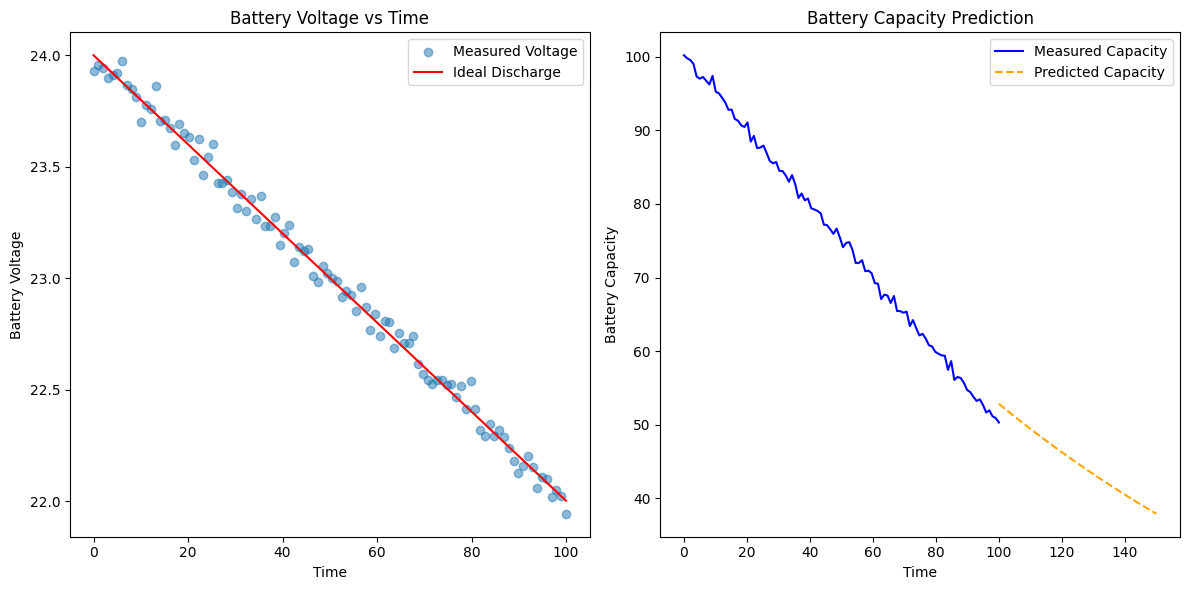

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# battery_history_data_simulation
np.random.seed(42)
time = np.linspace(0, 100, 100)
input_voltage = np.full_like(time, 14.0) + np.random.normal(110, 0.1, size=time.shape)  # input_voltage
battery_voltage = 24.0 - 0.02 * time + np.random.normal(0, 0.05, size=time.shape)  # battery_voltage
battery_capacity = 100 - 0.5 * time + np.random.normal(0, 0.5, size=time.shape)  # battery_capacity
load_level = np.full_like(time, 10.0) + np.random.normal(0, 1, size=time.shape)  # load_level

data = pd.DataFrame({
    "Time": time,
    "Input Voltage": input_voltage,
    "Battery Voltage": battery_voltage,
    "Battery Capacity": battery_capacity,
    "Load Level": load_level
})

# Define_the_ideal_battery_discharge_curve (assuming linear decay)
def discharge_curve(t, V_nom, k):
    return V_nom - k * t

# simulate_the_ideal_discharge_curve
params, _ = curve_fit(discharge_curve, data["Time"], data["Battery Voltage"])
V_nom_fit, k_fit = params

# 計算 SOH（電池健康狀態）
def calculate_soh(current_capacity, initial_capacity=100):
    return (current_capacity / initial_capacity) * 100

data["SOH"] = calculate_soh(data["Battery Capacity"])

# Exponential_decay_model_to_predict_future_capacity
def exp_decay(t, C0, lambda_):
    return C0 * np.exp(-lambda_ * t)

# 擬合指數衰減曲線
exp_params, _ = curve_fit(exp_decay, data["Time"], data["Battery Capacity"], p0=(100, 0.01))
C0_fit, lambda_fit = exp_params

# pridict_50_point_of_time
time_future = np.linspace(100, 150, 50)
predicted_capacity = exp_decay(time_future, C0_fit, lambda_fit)

# 繪圖
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data["Time"], data["Battery Voltage"], label="Measured Voltage", alpha=0.5)
plt.plot(data["Time"], discharge_curve(data["Time"], V_nom_fit, k_fit), label="Ideal Discharge", color='red')
plt.xlabel("Time")
plt.ylabel("Battery Voltage")
plt.legend()
plt.title("Battery Voltage vs Time")

plt.subplot(1, 2, 2)
plt.plot(data["Time"], data["Battery Capacity"], label="Measured Capacity", color='blue')
plt.plot(time_future, predicted_capacity, label="Predicted Capacity", linestyle='dashed', color='orange')
plt.xlabel("Time")
plt.ylabel("Battery Capacity")
plt.title("Battery Capacity Prediction")
plt.legend()

plt.tight_layout()
plt.show()

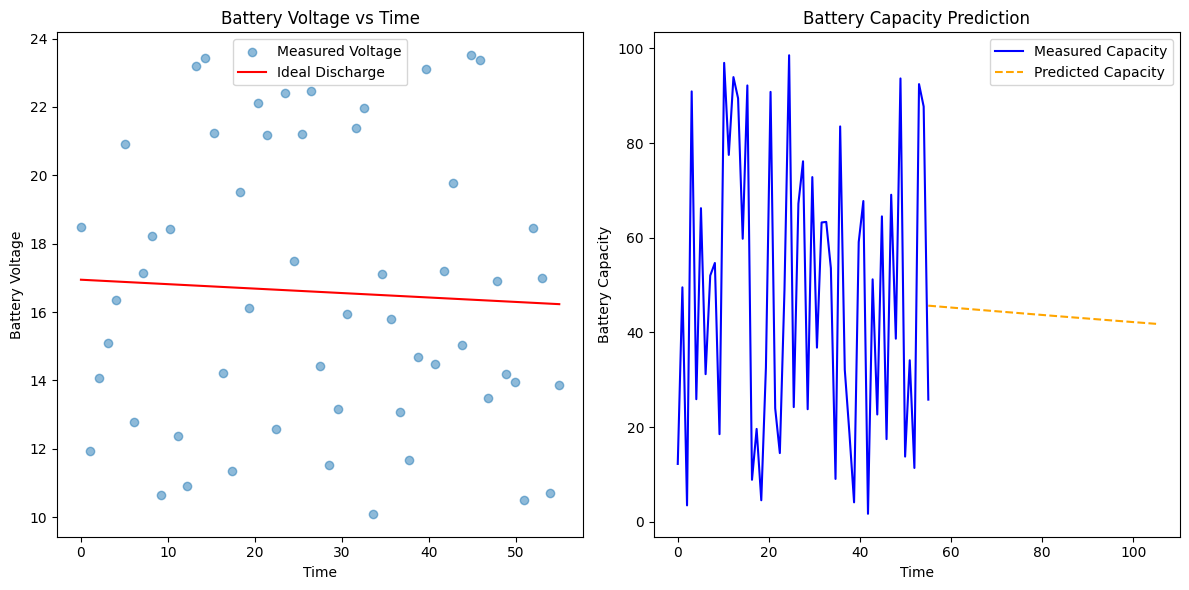

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# battery_history_data_simulation
time = np.linspace(0, 55, 55)
dt = open('/content/unhealthy_battery_data.csv', 'r', encoding='utf-8')

dt = pd.read_csv(dt)

dt
data = pd.DataFrame({
    "Time": time,
    "Input Voltage": dt.input_voltage,
    "Battery Voltage": dt.battery_voltage,
    "Battery Capacity": dt.battery_capacity,
    "Load Level": dt.load_level
})

# Define_the_ideal_battery_discharge_curve (assuming linear decay)
def discharge_curve(t, V_nom, k):
    return V_nom - k * t

# simulate_the_ideal_discharge_curve
params, _ = curve_fit(discharge_curve, data["Time"], data["Battery Voltage"])
V_nom_fit, k_fit = params

# 計算 SOH（電池健康狀態）
def calculate_soh(current_capacity, initial_capacity=100):
    return (current_capacity / initial_capacity) * 100

data["SOH"] = calculate_soh(data["Battery Capacity"])

# Exponential_decay_model_to_predict_future_capacity
def exp_decay(t, C0, lambda_):
    return C0 * np.exp(-lambda_ * t)

# 擬合指數衰減曲線
exp_params, _ = curve_fit(exp_decay, data["Time"], data["Battery Capacity"], p0=(100, 0.01))
C0_fit, lambda_fit = exp_params

# pridict_50_point_of_time
time_future = np.linspace(55, 105, 55)
predicted_capacity = exp_decay(time_future, C0_fit, lambda_fit)

# 繪圖
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data["Time"], data["Battery Voltage"], label="Measured Voltage", alpha=0.5)
plt.plot(data["Time"], discharge_curve(data["Time"], V_nom_fit, k_fit), label="Ideal Discharge", color='red')
plt.xlabel("Time")
plt.ylabel("Battery Voltage")
plt.legend()
plt.title("Battery Voltage vs Time")

plt.subplot(1, 2, 2)
plt.plot(data["Time"], data["Battery Capacity"], label="Measured Capacity", color='blue')
plt.plot(time_future, predicted_capacity, label="Predicted Capacity", linestyle='dashed', color='orange')
plt.xlabel("Time")
plt.ylabel("Battery Capacity")
plt.title("Battery Capacity Prediction")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
#當下電池狀態
S_current = np.array([112, 13.5, 100, 10, 13.5 / 24.0 * 100]).reshape(1, -1)
relevant_data = data[["Input Voltage", "Battery Voltage", "Battery Capacity", "Load Level", "SOH"]].values

cosine_similarity = 1 - cdist(S_current, relevant_data, metric='cosine')
B_idea_index = np.argmax(cosine_similarity)
print(B_idea_index)
relevant_data[B_idea_index]

11


array([109.98,  12.37,  77.51,  19.87,  77.51])

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import cosine

# PPO 策略網路
class PPOPolicy(nn.Module):
    def __init__(self, state_dim, action_dim):
      super(PPOPolicy, self).__init__()
      self.fc1 = nn.Linear(state_dim, 64)
      self.fc2 = nn.Linear(64, 32)
      self.fc3 = nn.Linear(32, action_dim)
      self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_probs = self.softmax(self.fc3(x))
        return action_probs

# 初始化 PPO 模型
state_dim = 5  # 5 個狀態變數
action_dim = 2  # 充電 (1) / 不充電 (0)
policy = PPOPolicy(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# 設定理想狀態 (S_ideal)
S_ideal = relevant_data[B_idea_index]



# 轉換成 PyTorch Tensor
S_current_tensor = torch.tensor(S_current, dtype=torch.float32)

# 使用 PPO 選擇充電策略
action_probs = policy(S_current_tensor)
action = torch.argmax(action_probs).item()  # 選擇機率最高的動作

# PPO 選擇的充電模式
charging_modes = {0: "不充電", 1: "充電"}
chosen_action = charging_modes[action]
print(f"PPO 選擇的充電策略: {chosen_action}")

# # 更新 S_PPO 狀態（模擬 PPO 選擇後的影響）
# if action == 1:  # 充電
#     S_PPO = S_current  # 充電後電壓上升，電池容量增加
# else:  # 不充電
#     S_PPO = S_current  # 保持原狀
S_PPO = S_current.flatten()

# 計算餘弦相似度
cosine_similarity = 1 - cosine(S_PPO, S_ideal)
print(f"餘弦相似度: {cosine_similarity:.4f}")

# 判斷 PPO 是否選擇了理想狀態
if cosine_similarity > 0.95:
    print("PPO 選擇的策略接近理想狀態")
    print(action)
    print(S_PPO)
    print(S_ideal)
else:
    print("PPO 可能需要調整")
    policy(S_current_tensor)
    print(not(action))

PPO 選擇的充電策略: 充電
餘弦相似度: 0.9794
PPO 選擇的策略接近理想狀態
1
[112.    13.5  100.    10.    56.25]
[109.98  12.37  77.51  19.87  77.51]


In [ ]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import PPO


class BatteryDataEnv(gym.Env):
    def __init__(self, csv_path):
        super().__init__()
        self.data = data
        # self.data = pd.read_csv(csv_path)
        self.max_voltage = 24.0
        self.max_capacity = 100
        self.reset()

        # 4個輸入特徵：input_voltage, battery_voltage, battery_capacity, load_level
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

        # 動作空間：0=保持不動，1=充電，2=放電
        self.action_space = spaces.Discrete(3)

    def reset(self):
        self.index = 0
        self.battery_health = 1.0
        return self._get_obs()

    def _get_obs(self):
        input_voltage = float(self.data[0])
        battery_voltage = self.data[1] / self.max_voltage
        battery_capacity = self.data[2] / 100
        load_level = self.data[-1]
        return np.array([input_voltage, battery_voltage, battery_capacity, load_level], dtype=np.float32)
        # if self.index >= len(self.data):
        #     self.index = 0
        # row = self.data.iloc[self.index]
        # return np.array([
        #     row["input_voltage"],
        #     row["battery_voltage"] / self.max_voltage,
        #     row["battery_capacity"] / 100,
        #     row["load_level"]
        # ], dtype=np.float32)

    def step(self, action):
        # row = self.data.iloc[self.index]
        # cap = row["battery_capacity"]
        # volt = row["battery_voltage"]
        # input_v = row["input_voltage"]
        # load = row["load_level"]
        row = self.data
        cap = float(row[2])
        volt = float(row[1])
        input_v = float(row[0])
        load = float(row[-1])
        reward = 0

        # 模擬行動效果（簡化）
        if action == 1:  # charge
            if input_v > 0.5:
                cap = min(100, cap + 3)
            else:
                reward -= 2
        elif action == 2:  # discharge
            if cap > 5:
                cap -= 5
                reward += load * 2
            else:
                reward -= 5

        volt = 3.0 + (cap / 100) * 1.2  # 模擬電壓變化
        if volt > 4.1 or volt < 3.0:
            self.battery_health -= 0.01
            reward -= 5
        else:
            self.battery_health -= 0.001

        if 40 <= cap <= 80:
            reward += 2

        reward += self.battery_health * 5

        self.index += 1
        done = self.index >= len(self.data) or self.battery_health <= 0.2
        return self._get_obs(), reward, done, {}

# 訓練 PPO 模型
csv_path = "/content/unhealthy_battery.csv"  # 放入你的資料路徑
data = [110, 24, 100, 0]
# env = BatteryDataEnv(csv_path)
env = BatteryDataEnv(data)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# 預測模型行為（輸出每筆資料該做什麼）
env.reset()
actions = []

for _ in range(len(env.data)):
    obs = env._get_obs()
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    _, _, done, _ = env.step(action)
    if done:
        break
# obs = env._get_obs()
# action, _ = model.predict(obs, deterministic=True)
# actions.append(action)
# _, _, done, _ = env.step(action)

actions
# # 整合動作回資料中
# env.data["ppo_action"] = actions
# # env.data["ppo_action"] = env.data["ppo_action"].map({0: "hold", 1: "charge", 2: "discharge"})
# env.data.to_csv("battery_with_actions.csv", index=False)
# print(env.data[["input_voltage", "battery_capacity", "ppo_action"]].head())

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | -0.5     |
| time/              |          |
|    fps             | 711      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 4            |
|    ep_rew_mean          | -0.5         |
| time/                   |              |
|    fps                  | 697          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0119703375 |
|    clip_fraction        | 0.0509       |
|    clip_range           | 0.2          |
|    en

[array(0), array(0), array(0), array(0)]

In [ ]:
dt = pd.read_csv('/content/battery_with_actions.csv')
data = pd.DataFrame({
    "Input Voltage": dt.input_voltage,
    "Battery Voltage": dt.battery_voltage,
    "Battery Capacity": dt.battery_capacity,
    "Load Level": dt.load_level,
    "Action": dt.ppo_action
    })
S_current = np.array([112, 13.5, 100, 10]).reshape(1, -1)
relevant_data = data[["Input Voltage", "Battery Voltage", "Battery Capacity", "Load Level"]].values

cosine_similarity = 1 - cdist(S_current, relevant_data, metric='cosine')
# B_idea_index = lambda x : x < 0.95
# B_idea_index(cosine_similarity)
B_idea_index = lambda x : 1 - cdist(S_current, relevant_data, metric='cosine') < 0.95
B_idea_index(cosine_similarity)
idx = np.argmax(B_idea_index)
print(data.loc[[idx]])
print(data.loc[[idx]]['Action'])

   Input Voltage  Battery Voltage  Battery Capacity  Load Level  Action
0            112             13.5               100          10       2
0    2
Name: Action, dtype: int64


In [ ]:
if